In [1]:
import os, glob
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import myutil.myutil as util

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

# Time to start considering the estimate
test_start = 4.9

wxx = 'w' +'155'
seq = f'cathhs_07'

gtr_path = f'/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/sequences/cathhs_*/gtr'

# The path to the experiment log
# xtrz_log = '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/sim_exp/sim_cloud_avia_mid_dynamic_extrinsics_gptr_two_lidar/run_00/time_0030/extrinsics_1.csv'

# The path to the gptr trajectory estimates
gptr_est_path = f'/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/gptr'

traj_trajlo_log_dir = f'/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/trajlo/'
print(traj_trajlo_log_dir)

traj_i2ekf_log_dir = f'/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/i2ekf/'
print(traj_i2ekf_log_dir)

traj_ctemlo_log_dir = f'/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/'
print(traj_ctemlo_log_dir)

# Lidar extrinsic
pose_B_L = [np.array([ 0,    0,  0,  0,    0,  0]),
            np.array([ 0,    90, 0,  0.117, 0, -0.141])]
T_B_L = []
for pose in pose_B_L:
	T = np.identity(4)
	T[0:3, 0:3] = util.eul2rotm(pose[0]/180*np.pi, pose[1]/180*np.pi, pose[2]/180*np.pi)
	T[0:3, 3] = pose[3:].T
	T_B_L.append(T)
	print("quat_B_L", util.rotm2quat(T[0:3, 0:3]))

T_L0_L1 = util.tfmult(util.tfinv(T_B_L[0]), T_B_L[1])
Rot01 = T_L0_L1[0:3, 0:3]
Pos01 = T_L0_L1[0:3, 3]
Eul01 = np.array(util.rotm2eul(Rot01))/math.pi*180
Qua01 = np.array(util.rotm2quat(Rot01))
print("xyz", Pos01)
print("ypr", Eul01)

/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/trajlo/
/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/i2ekf/
/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/
quat_B_L [1. 0. 0. 0.]
quat_B_L [0.70710678 0.         0.70710678 0.        ]
xyz [ 0.117  0.    -0.141]
ypr [ 0. 90. -0.]


In [2]:
# Load the gtr logs

# gtr_seqs  = [os.path.basename(seq) for seq in glob.glob(gtr_path + '/*')]
gtr_files = glob.glob(gtr_path + '/**/*.txt', recursive=True)
gtr_files = sorted(gtr_files)

# Load the ground truth
df_gtr = pd.DataFrame(gtr_files, columns=['gtr_file'])

# Determine the sequence
def findGtrSeq(x):
    parts = x.split('/')
    for part in parts:
        if 'cathhs_' in part:
            return int(part.replace('cathhs_', ''))
    return 'unknown'

# Determine the lidar index
def findGtrLidx(x):
    if 'lidar_0' in x:
        return 0
    elif 'lidar_1' in x:
        return 1
    else:
        return -1

# Load the data
df_gtr['data'] = df_gtr['gtr_file'].apply(lambda x: np.loadtxt(x, delimiter=' ', skiprows=1))

# Identify the sequence name and lidar idx
df_gtr['seq'] = df_gtr['gtr_file'].apply(lambda x: findGtrSeq(x))
df_gtr['lidx'] = df_gtr['gtr_file'].apply(lambda x: findGtrLidx(x))
# df_gtr = df_gtr.groupby(['seqname', 'lidx'])

# Calculate the ATE
def calculate_metric(traj_gtr, traj_est):
    metric = metrics.APE(pose_relation=metrics.PoseRelation.translation_part)
    metric.process_data((traj_gtr, traj_est))
    return float(metric.get_result(ref_name='reference', est_name='estimate').stats['rmse'])

print(df_gtr)

                                            gtr_file  \
0  /media/tmn/mySataSSD1/Experiments/tro_gptr_v2/...   
1  /media/tmn/mySataSSD1/Experiments/tro_gptr_v2/...   
2  /media/tmn/mySataSSD1/Experiments/tro_gptr_v2/...   
3  /media/tmn/mySataSSD1/Experiments/tro_gptr_v2/...   
4  /media/tmn/mySataSSD1/Experiments/tro_gptr_v2/...   
5  /media/tmn/mySataSSD1/Experiments/tro_gptr_v2/...   

                                                data  seq  lidx  
0  [[1.0, 1729595148.332405, 0.008557979017496109...    7     0  
1  [[1.0, 1729595148.332405, -0.11871199309825897...    7     1  
2  [[1.0, 1729595206.4733996, -0.0099504692479968...    8     0  
3  [[1.0, 1729595206.4733996, -0.1366415768861770...    8     1  
4  [[1.0, 1729595261.1508217, 0.00121730670798569...    9     0  
5  [[1.0, 1729595261.1508217, -0.1258094012737274...    9     1  


In [ ]:
# Access gptr method

def findSeq(x):
    parts = x.split('/')
    for part in parts:
        if 'cathhs_' in part:
            return int(part.replace('cathhs_', ''))
    return 'unknown'

def findMethod(x):
    parts = x.split('/')
    for part in parts:
        if 'exp_' in part:
            method = part
            method = method.replace('exp_', '')
            # print(method)
            if '0' in method:
                method = method.replace('0', 'CF')
            elif '1' in method:
                method = method.replace('1', 'AP')
            return method
    return 'unknown'

def findRun(x):
    parts = x.split('/')
    for part in parts:
        if 'run_' in part:
            run = int(part.replace('run_', ''))
            return run
    return -1

def findTime(x):
    parts = x.split('/')
    for part in parts:
        if 'time_' in part:
            time = float(part.replace('time_', ''))
            return time
    return 0

def findLidx(x):
    parts = x.split('/')
    for part in parts:
        if('gptraj_' in part):
            return int(part.replace('gptraj_', '').replace('.csv', ''))

def findRMSE(x):

    logfile = x['logfile']
    lidx = x['lidx']
    seq = x['seq']

    # rmse = -1
    # with open(logfile) as file:
    #     header = file.readline().strip()
    #     # print(header)
    #     parts = header.split(';')
    #     for part in parts:
    #         if "RMSE:" in part:
    #             rmse = float(part.replace('RMSE:', ''))*1000
    #             # print(rmse)
    #             return rmse
    # return rmse



    # Load the trajectory
    traj_est_data = np.loadtxt(logfile, delimiter=',', skiprows=1)
    traj_gtr_data = df_gtr[ (df_gtr['seq'] == seq) & (df_gtr['lidx'] == int(lidx)) ]['data'].iloc[0]

    # Get the traj_est
    tidx = list(np.where(traj_est_data[:, 1] > test_start)[0])
    traj_est = evotraj.PoseTrajectory3D(positions_xyz=traj_est_data[tidx, :][:, [12, 13, 14]], orientations_quat_wxyz=traj_est_data[tidx, :][:, [5, 2, 3, 4]], timestamps=traj_est_data[tidx, 1])
    t_est_max = traj_est.timestamps.max()

    # Get the traj gtr
    traj_gtr = traj_gtr_data
    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr[:, 2:5], orientations_quat_wxyz=traj_gtr[:, [8, 5, 6, 7]], timestamps=traj_gtr[:, 1])
    t_gtr_max = traj_gtr.timestamps.max()

    # if abs(t_est_max - t_gtr_max) > 1.0:
    #     # print('divergence', t_est_max, t_gtr_max, x)
    #     return -1

    traj_est, traj_gtr = sync.associate_trajectories(traj_est, traj_gtr, max_diff=0.2)
    T_G_E = traj_est.align(traj_gtr)
    # if lidx == 1:
    #     print(util.rotm2quat(T_G_E[0]))
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_est.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_est.orientations_quat_wxyz, timestamps=traj_est.timestamps)
    # Find the RMSE
    return calculate_metric(traj_est, traj_gtr)

def findXtrzLog(x):
    dirname = os.path.dirname(x)
    extrinsic_log = glob.glob(dirname + '/**/extrinsics_*.csv', recursive=True)[0]
    return extrinsic_log

traj_gptrc_logs = glob.glob(gptr_est_path + '/**/gptraj_*.csv', recursive=True)
traj_gptrc_logs = [log for log in traj_gptrc_logs if 'odom' not in log]

df_gptr = pd.DataFrame(traj_gptrc_logs, columns=['logfile'])
df_gptr['seq'] = df_gptr['logfile'].apply(lambda x : findSeq(x))
df_gptr['method'] = df_gptr['logfile'].apply(lambda x : findMethod(x))
df_gptr['run'] = df_gptr['logfile'].apply(lambda x : findRun(x))
df_gptr = df_gptr[df_gptr['run'] == 1]
df_gptr['lidx'] = df_gptr['logfile'].apply(lambda x : findLidx(x))
df_gptr['time'] = df_gptr['logfile'].apply(lambda x : findTime(x))
df_gptr = df_gptr.loc[df_gptr.groupby(['seq', 'method', 'run', 'lidx'])['time'].idxmax()]

# df_gptr['extrinsic_log'] = df_gptr['logfile'].apply(lambda x : findXtrzLog(x))

df_gptr['rmse'] = df_gptr.apply(lambda x : findRMSE(x), axis=1)

# df_gptr = df_gptr[['lidx', 'method', 'rmse']]
df_gptr_pvt = df_gptr.pivot(index=['seq', 'lidx'], columns=['method'], values='rmse')
print(df_gptr_pvt)


KeyboardInterrupt: 

: 

['/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/trajlo/cathhs_07/lidar0_estimated_pose_0.txt', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/trajlo/cathhs_07/lidar1_estimated_pose_0.txt', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/trajlo/cathhs_08/lidar0_estimated_pose_0.txt', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/trajlo/cathhs_08/lidar1_estimated_pose_0.txt', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/trajlo/cathhs_09/lidar0_estimated_pose_0.txt', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/trajlo/cathhs_09/lidar1_estimated_pose_0.txt']
method      TRAJLO
seq lidx          
7   0     0.027034
    1     0.044212
8   0     0.027758
    1     0.131871
9   0     0.042242
    1     0.056761


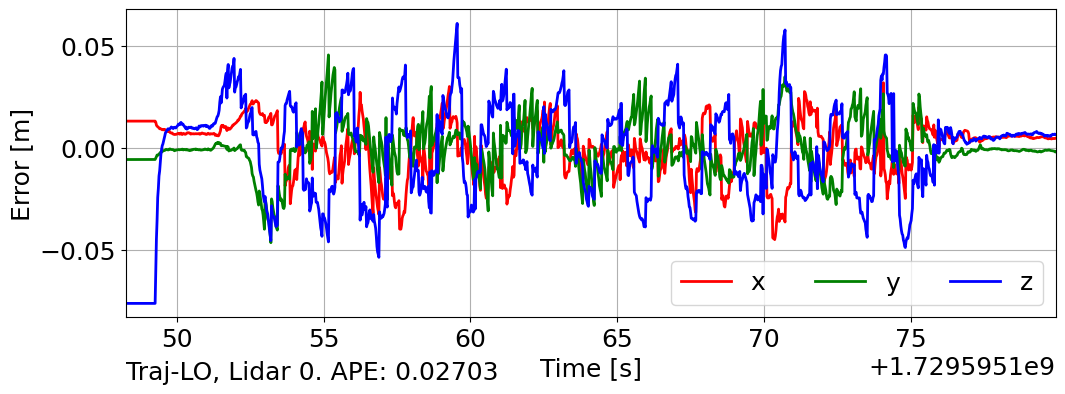

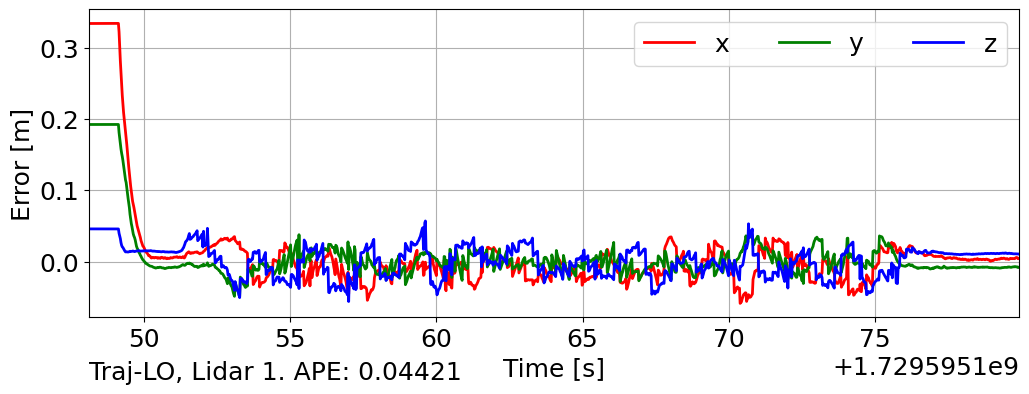

In [4]:
# Access TrajLO

def findRMSE(x):

    seq  = x['seq']
    lidx = x['lidx']

    traj_trajlo_data = x['data']
    traj_gtr_data = df_gtr[ (df_gtr['lidx'] == lidx) & (df_gtr['seq'] == seq) ]['data'].iloc[0]

    tidx = list(np.where( (traj_trajlo_data[:, 0] > test_start) )[0])
    traj_trajlo = evotraj.PoseTrajectory3D(positions_xyz=traj_trajlo_data[tidx, :][:, [1, 2, 3]], orientations_quat_wxyz=traj_trajlo_data[tidx, :][:, [7, 4, 5, 6]], timestamps=traj_trajlo_data[tidx, 0])
    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr_data[:, 2:5], orientations_quat_wxyz=traj_gtr_data[:, [8, 5, 6, 7]], timestamps=traj_gtr_data[:, 1])
    traj_trajlo, traj_gtr = sync.associate_trajectories(traj_trajlo, traj_gtr, max_diff=0.2)
    T_G_E = traj_trajlo.align(traj_gtr)
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_trajlo.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_trajlo.orientations_quat_wxyz, timestamps=traj_trajlo.timestamps)
    # Find the RMSE
    return calculate_metric(traj_trajlo, traj_gtr), traj_err

# Load the trajectory
traj_trajlo_logs = glob.glob(traj_trajlo_log_dir + '/**/*.txt', recursive=True)
print(traj_trajlo_logs)
df_trajlo = pd.DataFrame(traj_trajlo_logs, columns=['logfile'])
df_trajlo['seq'] = df_trajlo['logfile'].apply(lambda x : findSeq(x))
df_trajlo['method'] = df_trajlo['logfile'].apply(lambda x : 'TRAJLO')
# df_trajlo['run'] = df_trajlo['logfile'].apply(lambda x : 0)
df_trajlo['lidx'] = df_trajlo['logfile'].apply(lambda x : 0 if 'lidar0' in x else 1)
df_trajlo['data'] = df_trajlo['logfile'].apply(lambda x : np.loadtxt(x, delimiter=' ', skiprows=1))
df_trajlo[['rmse', 'error']] = df_trajlo.apply(lambda x : findRMSE(x), axis=1, result_type='expand')

lidars = list(set(df_trajlo['lidx'].tolist()))

# # Calculate the variance of trajlo est
# import statistics
# for lidx in lidars:
#     print(f"variance {lidx}", statistics.variance(df_trajlo[ df_trajlo['lidx'] == lidx]['rmse'].tolist() ))

# Extract the exp with minimum rmse for each lidx
df_trajlo = df_trajlo.loc[df_trajlo.groupby(['seq', 'lidx'])['rmse'].idxmin()]

# trajlo_data = []
# for lidx in lidars:
#     df_temp = df_trajlo[df_trajlo['lidx'] == lidx]
#     min_row = df_temp.loc[df_temp['rmse'].idxmin()]
#     trajlo_data.append(min_row)
#     print(lidx, min_row['rmse'])

for lidx in lidars:

    data = df_trajlo[df_trajlo['lidx'] == lidx]

    # lidx = data['lidx']
    traj_err = data['error'].iloc[0]
    rmse = data['rmse'].iloc[0]

    plt.rcParams.update({'font.size':18})
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
    ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

    # Stamp the ATE
    ax.text(0, -0.2, f'Traj-LO, Lidar {lidx}. APE: {rmse:.5f}', transform=ax.transAxes)

    ax.set_xlim([np.min(traj_err.timestamps), np.max(traj_err.timestamps-1.0)])
    # ax.set_ylim([-0.06, 0.06])
    ax.legend(ncols=3)
    ax.grid('on')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Error [m]')


# Create boxplot
# ax, fig = plt.subplots(1, 1, figsize=(5, 5))
# fig.boxplot([traj_trajlo_lidar0_rmse, traj_trajlo_lidar1_rmse], labels=['List 1', 'List 2'])
# df_trajlo = df_trajlo[['lidx', 'method', 'rmse']]
df_trajlo_pvt = df_trajlo.pivot(index=['seq', 'lidx'], columns=['method'], values='rmse')
print(df_trajlo_pvt)



In [5]:
# Assess the i2ekf

def findTry(x):
    parts = x.split('/')
    for part in parts:
        if 'try_' in part:
            run = int(part.replace('try_', ''))
            return run
    return -1

def findRMSE(x):

    lidx = x['lidx']
    seq = x['seq']

    traj_i2ekf_data = x['data']
    traj_gtr_data = df_gtr[ (df_gtr['lidx'] == lidx) & (df_gtr['seq'] == seq) ]['data'].iloc[0]

    tidx = list(np.where( (traj_i2ekf_data[:, 0] > test_start) )[0])
    traj_i2ekf = evotraj.PoseTrajectory3D(positions_xyz=traj_i2ekf_data[tidx, :][:, [1, 2, 3]], orientations_quat_wxyz=traj_i2ekf_data[tidx, :][:, [7, 4, 5, 6]], timestamps=traj_i2ekf_data[tidx, 0])
    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr_data[:, 2:5], orientations_quat_wxyz=traj_gtr_data[:, [8, 5, 6, 7]], timestamps=traj_gtr_data[:, 1])
    traj_i2ekf, traj_gtr = sync.associate_trajectories(traj_i2ekf, traj_gtr, max_diff=0.2)
    T_G_E = traj_i2ekf.align(traj_gtr)
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_i2ekf.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_i2ekf.orientations_quat_wxyz, timestamps=traj_i2ekf.timestamps)
    rmse = calculate_metric(traj_i2ekf, traj_gtr)
    return rmse, traj_err

# Load the trajectory
traj_i2ekf_logs = glob.glob(traj_i2ekf_log_dir + '/**/i2ekf_lidar*.csv', recursive=True)
df_i2ekf = pd.DataFrame(traj_i2ekf_logs, columns=['logfile'])
df_i2ekf['seq']    = df_i2ekf['logfile'].apply(lambda x : findSeq(x))
df_i2ekf['method'] = df_i2ekf['logfile'].apply(lambda x : 'I2EKF')
df_i2ekf['try']    = df_i2ekf['logfile'].apply(lambda x : findTry(x))
# print(df_i2ekf)
df_i2ekf['lidx']   = df_i2ekf['logfile'].apply(lambda x : 0 if 'lidar0' in x else 1)
df_i2ekf['data']   = df_i2ekf['logfile'].apply(lambda x : np.loadtxt(x, skiprows=1))
df_i2ekf[['rmse', 'error']] = df_i2ekf.apply(lambda x : findRMSE(x), axis=1, result_type='expand')

df_i2ekf['mrmse'] = df_i2ekf.groupby(['seq', 'method', 'try'])['rmse'].transform('mean')
df_i2ekf = df_i2ekf.loc[df_i2ekf.groupby(['seq', 'method', 'lidx'])['mrmse'].idxmin()]
df_i2ekf = df_i2ekf.drop(['try', 'mrmse'], axis=1)
# print(df_i2ekf)

# lidars = list(set(df_i2ekf['lidx'].tolist()))
# # Calculate the variance of trajlo est
# import statistics
# for lidx in lidars:
#     print(f"variance {lidx}", statistics.variance(df_i2ekf[ df_i2ekf['lidx'] == lidx]['rmse'].tolist() ))

# Extract the exp with minimum rmse for each lidx
df_i2ekf_pvt = df_i2ekf.pivot(index=['seq', 'lidx'], columns='method', values='rmse')
print(df_i2ekf_pvt)

method       I2EKF
seq lidx          
7   0     0.047568
    1     0.679347
8   0     0.064736
    1     0.043019
9   0     0.047681
    1     3.344801


In [6]:
# Access the ctemlo traj

def findTry(x):
    parts = x.split('/')
    for part in parts:
        if 'try_' in part:
            run = int(part.replace('try_', ''))
            return run
    return -1

def findRMSE(x):

    traj_ctemlo_data = x['data']

    lidx = x['lidx']
    seq = x['seq']

    traj_gtr_data = df_gtr[ (df_gtr['lidx'] == lidx) & (df_gtr['seq'] == seq) ]['data'].iloc[0]

    tidx = list(np.where( (traj_ctemlo_data[:, 0] > test_start) )[0])
    traj_ctemlo = evotraj.PoseTrajectory3D(positions_xyz=traj_ctemlo_data[tidx, :][:, [1, 2, 3]], orientations_quat_wxyz=traj_ctemlo_data[tidx, :][:, [7, 4, 5, 6]], timestamps=traj_ctemlo_data[tidx, 0])
    traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr_data[:, 2:5], orientations_quat_wxyz=traj_gtr_data[:, [8, 5, 6, 7]], timestamps=traj_gtr_data[:, 1])
    traj_ctemlo, traj_gtr = sync.associate_trajectories(traj_ctemlo, traj_gtr, max_diff=0.2)
    T_G_E = traj_ctemlo.align(traj_gtr)
    traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_ctemlo.positions_xyz - traj_gtr.positions_xyz, \
                                        orientations_quat_wxyz=traj_ctemlo.orientations_quat_wxyz, timestamps=traj_ctemlo.timestamps)
    rmse = calculate_metric(traj_ctemlo, traj_gtr)
    return rmse, traj_err

# Load the trajectory
traj_ctemlo_logs = glob.glob(traj_ctemlo_log_dir + '/**/ctemlo_lidar*.csv', recursive=True)

print(traj_ctemlo_logs)

df_ctemlo = pd.DataFrame(traj_ctemlo_logs, columns=['logfile'])
df_ctemlo['seq']    = df_ctemlo['logfile'].apply(lambda x : findSeq(x))
df_ctemlo['method'] = df_ctemlo['logfile'].apply(lambda x : 'CTEMLO')
df_ctemlo['try']    = df_ctemlo['logfile'].apply(lambda x : findTry(x))
df_ctemlo['lidx']   = df_ctemlo['logfile'].apply(lambda x : 0 if 'lidar0' in x else 1)
df_ctemlo['data']   = df_ctemlo['logfile'].apply(lambda x : np.loadtxt(x, skiprows=1))
df_ctemlo[['rmse', 'error']] = df_ctemlo.apply(lambda x : findRMSE(x), axis=1, result_type='expand')

df_ctemlo['mrmse'] = df_ctemlo.groupby(['seq', 'method', 'try'])['rmse'].transform('mean')
df_ctemlo = df_ctemlo.loc[df_ctemlo.groupby(['seq', 'method', 'lidx'])['mrmse'].idxmin()]
# print(df_ctemlo[['seq', 'method', 'try', 'lidx', 'rmse', 'mrmse']])
df_ctemlo = df_ctemlo.drop(['try', 'mrmse'], axis=1)
# print(df_ctemlo)

# lidars = list(set(df_i2ekf['lidx'].tolist()))
# # Calculate the variance of trajlo est
# import statistics
# for lidx in lidars:
#     print(f"variance {lidx}", statistics.variance(df_i2ekf[ df_i2ekf['lidx'] == lidx]['rmse'].tolist() ))

# Extract the exp with minimum rmse for each lidx
df_ctemlo_pvt = df_ctemlo.pivot(index=['seq', 'lidx'], columns='method', values='rmse')
print(df_ctemlo_pvt)

['/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/cathhs_07/try_0/ctemlo_lidar0.csv', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/cathhs_07/try_0/ctemlo_lidar1.csv', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/cathhs_07/try_1/ctemlo_lidar0.csv', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/cathhs_07/try_1/ctemlo_lidar1.csv', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/cathhs_07/try_2/ctemlo_lidar0.csv', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/cathhs_07/try_2/ctemlo_lidar1.csv', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/cathhs_08/try_0/ctemlo_lidar0.csv', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/cathhs_08/try_0/ctemlo_lidar1.csv', '/media/tmn/mySataSSD1/Experiments/tro_gptr_v2/logs/lio/hhs_exp/ctemlo/cathhs_08/try_1/ctemlo_lidar0.csv', '/media/tmn/mySataSSD1/Experiments/t

In [7]:
# Combine the results

df_trajlo = df_trajlo[['seq', 'lidx', 'method', 'rmse']]
df_i2ekf  = df_i2ekf[['seq', 'lidx', 'method', 'rmse']]
df_ctemlo = df_ctemlo[['seq', 'lidx', 'method', 'rmse']]
# df_ctemlo['rmse'] = np.inf
# df_ctemlo['method'] = 'CTEMLO'
print(df_ctemlo)

df_gptr   = df_gptr[['seq', 'lidx', 'method', 'rmse']]

df_combibed = pd.concat([df_trajlo, df_i2ekf, df_ctemlo, df_gptr], axis=0)
df_combibed = df_combibed.sort_values(by='lidx')
df_combibed = df_combibed.pivot(index=['seq', 'lidx'], columns='method', values='rmse')

cols = ['I2EKF', 'TRAJLO', 'CTEMLO'] + [col for col in df_combibed.columns if col not in ['TRAJLO', 'I2EKF'] and 'CF' in col ]
df_combibed = df_combibed[cols]
# df_combined = df_combibed['CF' in df_combibed['method']]

df_combibed = df_combibed.round(4)
df_combibed[df_combibed > 1.0] = np.inf

print(df_combibed)

def makeLatexTable(df_):
    df = df_
    for idx, row in df.iterrows():
        sorted_cols = row.sort_values().index  # columns sorted by value
        min_col = sorted_cols[0]
        second_min_col = sorted_cols[1]
        for col in df.columns:
            val = row[col]
            if col == min_col:
                df.at[idx, col] = f"\\textbf{{{val}}}"
            elif col == second_min_col:
                df.at[idx, col] = f"\\underline{{{val}}}"
            else:
                df.at[idx, col] = f"{val}"

    # Export to LaTeX
    latex_str = df.to_latex(escape=False)
    return latex_str

latextable = makeLatexTable(df_combibed)\
            .replace("textbf", "bf")\
            .replace("underline", "ul")\
            .replace('multirow', 'mr')\
            .replace('multicol', 'mc')\
            .replace('\mr[t]', '\mr[c]')\
            .replace('w', '0.')\
            .replace('inf', 'x')

print(latextable)

    seq  lidx  method      rmse
4     7     0  CTEMLO  0.042973
5     7     1  CTEMLO  0.041705
6     8     0  CTEMLO  0.041980
7     8     1  CTEMLO  0.041766
16    9     0  CTEMLO  0.055402
17    9     1  CTEMLO  0.056733
method     I2EKF  TRAJLO  CTEMLO  SE3_CF  SO3xR3_CF
seq lidx                                           
7   0     0.0476  0.0270  0.0430  0.0236     0.0233
    1     0.6793  0.0442  0.0417  0.0285     0.0272
8   0     0.0647  0.0278  0.0420  0.0234     0.0233
    1     0.0430  0.1319  0.0418  0.0316     0.0310
9   0     0.0477  0.0422  0.0554  0.0401     0.0394
    1        inf  0.0568  0.0567  0.0452     0.0445
\begin{tabular}{lllllll}
\toprule
 & method & I2EKF & TRAJLO & CTEMLO & SE3_CF & SO3xR3_CF \\
seq & lidx &  &  &  &  &  \\
\midrule
\mr[c]{2}{*}{7} & 0 & 0.0476 & 0.027 & 0.043 & \ul{0.0236} & \bf{0.0233} \\
 & 1 & 0.6793 & 0.0442 & 0.0417 & \ul{0.0285} & \bf{0.0272} \\
\cline{1-7}
\mr[c]{2}{*}{8} & 0 & 0.0647 & 0.0278 & 0.042 & \ul{0.0234} & \bf{0.0233} \\


<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3693616/2383201907.py:49: SyntaxWarning: invalid escape sequence '\m'
  .replace('\mr[t]', '\mr[c]')\
/tmp/ipykernel_3693616/2383201907.py:49: SyntaxWarning: invalid escape sequence '\m'
  .replace('\mr[t]', '\mr[c]')\
/tmp/ipykernel_3693616/2383201907.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0476' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, col] = f"{val}"
/tmp/ipykernel_3693616/2383201907.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.027' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


In [8]:
# # Access the i2ekf traj

# def findRMSE(traj_i2ekf_data, traj_gtr_data):
#     tidx = list(np.where( (traj_i2ekf_data[:, 0] > test_start) )[0])
#     traj_i2ekf = evotraj.PoseTrajectory3D(positions_xyz=traj_i2ekf_data[tidx, :][:, [1, 2, 3]], orientations_quat_wxyz=traj_i2ekf_data[tidx, :][:, [7, 4, 5, 6]], timestamps=traj_i2ekf_data[tidx, 0])
#     traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr_data[:, 0:3], orientations_quat_wxyz=traj_gtr_data[:, [8, 5, 6, 7]], timestamps=traj_gtr_data[:, 3])
#     traj_i2ekf, traj_gtr = sync.associate_trajectories(traj_i2ekf, traj_gtr, max_diff=0.2)
#     traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_i2ekf.positions_xyz - traj_gtr.positions_xyz, \
#                                         orientations_quat_wxyz=traj_i2ekf.orientations_quat_wxyz, timestamps=traj_i2ekf.timestamps)
#     rmse = calculate_metric(traj_i2ekf, traj_gtr)
#     return rmse, traj_err

# # Load the trajectory
# traj_i2ekf_logs = glob.glob(traj_i2ekf_log_dir + '/i2ekf_lidar*.csv')

# df_i2ekf = pd.DataFrame(traj_i2ekf_logs, columns=['logfile'])
# df_i2ekf['lidx'] = df_i2ekf['logfile'].apply(lambda x : 0 if 'lidar0' in x else 1)
# df_i2ekf['data'] = df_i2ekf['logfile'].apply(lambda x : np.loadtxt(x, skiprows=11))
# df_i2ekf[['rmse', 'error']] = df_i2ekf.apply(lambda x : findRMSE(x['data'], df_gtr[df_gtr['lidx'] == x['lidx']]['data'].iloc[0]), axis=1, result_type='expand')
# df_i2ekf['method'] = df_i2ekf['logfile'].apply(lambda x : 'I2EKF')

# lidars = list(set(df_i2ekf['lidx'].tolist()))

# # Calculate the variance of trajlo est
# import statistics
# for lidx in lidars:
#     print(f"variance {lidx}", statistics.variance(df_i2ekf[ df_i2ekf['lidx'] == lidx]['rmse'].tolist() ))

# # Extract the exp with minimum rmse for each lidx
# df_i2ekf = df_i2ekf.loc[df_i2ekf.groupby('lidx')['rmse'].idxmin()]

# for lidx in lidars:

#     data = df_i2ekf[df_i2ekf['lidx'] == lidx]

#     # lidx = data['lidx']
#     traj_err = data['error'].iloc[0]
#     rmse = data['rmse'].iloc[0]

#     plt.rcParams.update({'font.size':18})
#     fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
#     ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
#     ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
#     ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

#     # Stamp the ATE
#     ax.text(0, -0.2, f'Traj-LO, Lidar {lidx}. APE: {rmse:.5f}', transform=ax.transAxes)

#     ax.set_xlim([np.min(traj_err.timestamps), np.max(traj_err.timestamps-1.0)])
#     # ax.set_ylim([-0.06, 0.06])
#     ax.legend(ncols=3)
#     ax.grid('on')
#     ax.set_xlabel('Time [s]')
#     ax.set_ylabel('Error [m]')


# # Create boxplot
# # ax, fig = plt.subplots(1, 1, figsize=(5, 5))
# # fig.boxplot([traj_trajlo_lidar0_rmse, traj_trajlo_lidar1_rmse], labels=['List 1', 'List 2'])
# # df_trajlo = df_trajlo[['lidx', 'method', 'rmse']]
# df_i2ekf_pvt = df_i2ekf[['lidx', 'method', 'rmse']].pivot(index='lidx', columns='method', values='rmse')
# print(df_i2ekf_pvt)

In [9]:
# # Load the extrinsic data
# xtrz_data = np.loadtxt(xtrz_log, delimiter=',', skiprows=1)
# txtrz = xtrz_data[:, 0]

# # Calculate the position data
# p_L0_L1_est = xtrz_data[:, 1:4]
# p_L0_L1_err = np.zeros(p_L0_L1_est.shape)
# p_L0_L1_gtr = np.zeros(p_L0_L1_est.shape)
# for idx, t in enumerate(txtrz):
#     if 10 < t < 20:
#         p_L0_L1_gtr[idx, :] = p_L0_L1_est[idx, :] - Pos01_slip
#         p_L0_L1_gtr[idx, :] = Pos01_slip
#     else:
#         p_L0_L1_err[idx, :] = p_L0_L1_est[idx, :] - Pos01
#         p_L0_L1_gtr[idx, :] = Pos01

# # Calculate the oritation error
# Q_L0_L1_est = []
# E_L0_L1_est = []
# E_L0_L1_err = []
# for idx, t in enumerate(txtrz):
#     q = xtrz_data[idx, [7, 4, 5, 6]]
#     Q_L0_L1_est.append(util.quat2rotm(q))
#     E_L0_L1_est.append(list(util.quat2eul(q)))
#     E_L0_L1_err.append(list(util.rotm2eul(Q_L0_L1_est[-1].transpose()@Rot01)))

# E_L0_L1_est = np.array(E_L0_L1_est).reshape((-1, 3))
# E_L0_L1_err = np.array(E_L0_L1_err).reshape((-1, 3))

# # Plot the error
# plt.rcParams.update({'font.size':18})
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))

# ax.plot(txtrz, p_L0_L1_est[:, 0], linewidth=2, color='r', label='x est.')
# ax.plot(txtrz, p_L0_L1_gtr[:, 0], linewidth=2, color='r', label='x GT', linestyle='--')

# ax.plot(txtrz, p_L0_L1_est[:, 1], linewidth=2, color='g', label='y est.')
# ax.plot(txtrz, p_L0_L1_gtr[:, 1], linewidth=2, color='g', label='y GT', linestyle='--')

# ax.plot(txtrz, p_L0_L1_est[:, 2], linewidth=2, color='b', label='z est.')
# ax.plot(txtrz, p_L0_L1_gtr[:, 2], linewidth=2, color='b', label='z GT', linestyle='--')

# ax.text(x=0.1, y=0.8, s=f'Final error: \n   ({p_L0_L1_err[-1, 0]:.3f}, {p_L0_L1_err[-1, 1]:.3f}, {p_L0_L1_err[-1, 2]:.3f})', transform=ax.transAxes)

# # ax.set_xlim([5, 15])
# ax.grid('on')
# ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0.05, 0.65))

# ax.set_xlabel('Time [s]')
# ax.set_ylabel('Trans. Extrinsics [m]')
# # plt.tight_layout()
# fig.canvas.draw()
# fig.savefig('trans_extrinsics_error.jpg', bbox_inches='tight', dpi=300)

# # Plot the error
# plt.rcParams.update({'font.size':18})
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))

# ax.plot(txtrz, E_L0_L1_err[:, 0]/np.pi*180, linewidth=2, color='r', label='yaw')
# ax.plot(txtrz, E_L0_L1_err[:, 1]/np.pi*180, linewidth=2, color='g', label='pitch')
# ax.plot(txtrz, E_L0_L1_err[:, 2]/np.pi*180, linewidth=2, color='b', label='raw')

# ax.grid('on')
# ax.legend(ncol=3, bbox_to_anchor=(0.4, 0.35))

# ax.set_xlabel('Time [s]')
# ax.set_ylabel('Rot. Extr. Est. Error [deg]')

# # plt.tight_layout()
# fig.canvas.draw()
# fig.savefig('rot_extrinsics_error.jpg', bbox_inches='tight', dpi=300)

In [10]:
import pandas as pd

# Sample DataFrame
data = {
    'TRAJLO': [0.064545, 0.057270],
    'I2EKF': [0.057025, 0.049441],
    'SE3_AP': [0.033506, 0.039525],
    'SE3_CF': [0.033593, 0.039484],
    'SO3xR3_AP': [0.033498, 0.039336],
    'SO3xR3_CF': [0.033639, 0.039300]
}
index = [0, 1]
df = pd.DataFrame(data, index=index)
df.index.name = 'lidx'

print("Original DataFrame:")
print(df)

# Find the minimum value per row
min_idx = df.idxmin(axis=1)

# Create a copy for LaTeX formatting
df_latex = df.copy()

# Apply bold formatting for the minimum value in each row
for idx in df.index:
    for col in df.columns:
        val = df.at[idx, col]
        if col == min_idx[idx]:
            df_latex.at[idx, col] = f"\\textbf{{{val:.6f}}}"
        else:
            df_latex.at[idx, col] = f"{val:.6f}"

# Export to LaTeX
latex_str = df_latex.to_latex(escape=False)

print("\nGenerated LaTeX Table:")
print(latex_str)


Original DataFrame:
        TRAJLO     I2EKF    SE3_AP    SE3_CF  SO3xR3_AP  SO3xR3_CF
lidx                                                              
0     0.064545  0.057025  0.033506  0.033593   0.033498   0.033639
1     0.057270  0.049441  0.039525  0.039484   0.039336   0.039300

Generated LaTeX Table:
\begin{tabular}{lllllll}
\toprule
 & TRAJLO & I2EKF & SE3_AP & SE3_CF & SO3xR3_AP & SO3xR3_CF \\
lidx &  &  &  &  &  &  \\
\midrule
0 & 0.064545 & 0.057025 & 0.033506 & 0.033593 & \textbf{0.033498} & 0.033639 \\
1 & 0.057270 & 0.049441 & 0.039525 & 0.039484 & 0.039336 & \textbf{0.039300} \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3693616/1313471214.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.064545' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_latex.at[idx, col] = f"{val:.6f}"
/tmp/ipykernel_3693616/1313471214.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.057025' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_latex.at[idx, col] = f"{val:.6f}"
/tmp/ipykernel_3693616/1313471214.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.033506' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_latex.at[idx, col] = f"{val:.6f}"
/tmp/ipykernel_3693616/1313471214.py:32: FutureWarning: Setting an item of i

In [11]:
# # Load the trajectory
# traj_est1lidar_data = []
# for log in traj_est1lidar_logs:
#     traj_est1lidar_data.append(np.loadtxt(log, delimiter=',', skiprows=1))

# traj_gtr_data = []
# for log in traj_gtr_logs:
#     traj_gtr_data.append(np.loadtxt(log, delimiter=' ', skiprows=11))

# for lidx in range(len(traj_est1lidar_data)):

#     # Get the traj_est
#     traj_est1lidar = traj_est1lidar_data[lidx]
#     tidx = list(np.where(traj_est1lidar[:, 1] > test_start)[0])
#     traj_est1lidar = evotraj.PoseTrajectory3D(positions_xyz=traj_est1lidar[tidx, :][:, [12, 13, 14]], orientations_quat_wxyz=traj_est1lidar[tidx, :][:, [5, 2, 3, 4]], timestamps=traj_est1lidar[tidx, 1])

#     # Get the traj gtr
#     traj_gtr = traj_gtr_data[lidx]
#     traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr[:, 0:3], orientations_quat_wxyz=traj_gtr[:, [8, 5, 6, 7]], timestamps=traj_gtr[:, 3])

#     traj_est1lidar, traj_gtr = sync.associate_trajectories(traj_est1lidar, traj_gtr, max_diff=0.2)
#     traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_est1lidar.positions_xyz - traj_gtr.positions_xyz, \
#                                         orientations_quat_wxyz=traj_est1lidar.orientations_quat_wxyz, timestamps=traj_est1lidar.timestamps)

#     # Find the RMSE
#     rmse = calculate_metric(traj_est1lidar, traj_gtr)

#     plt.rcParams.update({'font.size':18})
#     fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
#     ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
#     ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
#     ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

#     # Stamp the ATE
#     ax.text(0, -0.2, f'GPTR-U, Lidar {lidx}. APE: {rmse:.5f}', transform=ax.transAxes)

#     ax.set_xlim([np.min(traj_est1lidar.timestamps), np.max(traj_est1lidar.timestamps-1.0)])
#     # ax.set_ylim([-0.06, 0.06])
#     ax.legend(ncols=3)
#     ax.grid('on')
#     ax.set_xlabel('Time [s]')
#     ax.set_ylabel('Error [m]')


In [12]:
# # Load the trajectory
# traj_estkf_data = []
# for log in traj_estkf_logs:
#     traj_estkf_data.append(np.loadtxt(log, delimiter=' ', skiprows=11))

# traj_gtr_data = []
# for log in traj_gtr_logs:
#     traj_gtr_data.append(np.loadtxt(log, delimiter=' ', skiprows=11))

# for lidx in range(len(traj_estkf_data)):

#     # Get the traj_estkf
#     traj_estkf = traj_estkf_data[lidx]
#     tidx = list(np.where(traj_estkf[:, 4] > test_start)[0])
#     traj_estkf = evotraj.PoseTrajectory3D(positions_xyz=traj_estkf[tidx, :][:, [0, 1, 2]], orientations_quat_wxyz=traj_estkf[tidx, :][:, [8, 5, 6, 7]], timestamps=traj_estkf[tidx, 4])

#     # Get the traj gtr
#     traj_gtr = traj_gtr_data[lidx]
#     traj_gtr = evotraj.PoseTrajectory3D(positions_xyz=traj_gtr[:, 0:3], orientations_quat_wxyz=traj_gtr[:, [8, 5, 6, 7]], timestamps=traj_gtr[:, 3])

#     traj_estkf, traj_gtr = sync.associate_trajectories(traj_estkf, traj_gtr, max_diff=0.2)
#     traj_err = evotraj.PoseTrajectory3D(positions_xyz=traj_estkf.positions_xyz - traj_gtr.positions_xyz, \
#                                         orientations_quat_wxyz=traj_estkf.orientations_quat_wxyz, timestamps=traj_estkf.timestamps)

#     # Find the RMSE
#     rmse = calculate_metric(traj_estkf, traj_gtr)

#     plt.rcParams.update({'font.size':18})
#     fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 4))
#     ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 0], 'r', linewidth=2, label='x')
#     ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 1], 'g', linewidth=2, label='y')
#     ax.plot(traj_err.timestamps, traj_err.positions_xyz[:, 2], 'b', linewidth=2, label='z')

#     # Stamp the ATE
#     ax.text(0, -0.2, f'IEKF, Lidar {lidx}. APE: {rmse:.5f}', transform=ax.transAxes)

#     ax.set_xlim([np.min(traj_estkf.timestamps), np.max(traj_estkf.timestamps-1.0)])
#     # ax.set_ylim([-0.06, 0.06])
#     ax.legend(ncols=3)
#     ax.grid('on')
#     ax.set_xlabel('Time [s]')
#     ax.set_ylabel('Error [m]')